<a href="https://colab.research.google.com/github/Manoj-Kumar-8/cbps/blob/server/MiniFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
# -*- coding: utf-8 -*-
"""STEP 1: Setup & Installation"""

!pip install transformers torch pandas numpy scikit-learn matplotlib seaborn gradio contractions emoji nltk

import nltk
nltk.download(['punkt', 'wordnet', 'omw-1.4'])  # Added omw-1.4 for WordNet
nltk.download('punkt_tab')  # Specifically for Punkt tokenizer tables

from google.colab import drive
drive.mount('/content/drive')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import pandas as pd
import numpy as np
import os
import re
import emoji
import contractions
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import nltk
nltk.download(['punkt', 'wordnet'])

# Configuration
NEW_MODEL_PATH = '/content/drive/MyDrive/sentiment_model_fresh.pth'
NEW_OUTPUT_DIR = '/content/drive/MyDrive/sentiment_results_fresh'
os.makedirs(NEW_OUTPUT_DIR, exist_ok=True)

MAX_LEN = 256
BATCH_SIZE = 16
EPOCHS = 3
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [44]:
"""STEP 2: Data Preparation"""

class TextPreprocessor:
    def __init__(self):
        nltk.download('punkt_tab', quiet=True)  # Ensure punkt_tab is available
        self.lemmatizer = nltk.WordNetLemmatizer()

    def clean_text(self, text):
        text = str(text).lower()
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'http\S+|www\S+|@\w+', '', text)
        text = emoji.demojize(text)
        text = contractions.fix(text)
        text = re.sub(r'[^\w\s.,!?]', '', text)
        try:
            tokens = nltk.word_tokenize(text)
        except LookupError:
            nltk.download('punkt_tab')
            tokens = nltk.word_tokenize(text)
        return ' '.join([self.lemmatizer.lemmatize(token) for token in tokens])

def load_data():
    df = pd.read_csv('/content/drive/MyDrive/MiniProject/IMDB Dataset.csv')
    df['sentiment'] = df['sentiment'].map({'negative':0, 'positive':1})

    preprocessor = TextPreprocessor()
    df['cleaned_review'] = df['review'].apply(preprocessor.clean_text)

    train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sentiment'], random_state=42)
    train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['sentiment'], random_state=42)

    return train_df, val_df, test_df

In [45]:
"""STEP 3: Dataset & Model Setup"""

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

class FreshSentimentModel(nn.Module):
    def __init__(self, n_classes=2):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(0.3)
        self.conv1 = nn.Conv1d(768, 256, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.classifier = nn.Linear(128, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state.permute(0, 2, 1)
        x = torch.relu(self.conv1(hidden_state))
        x = torch.relu(self.conv2(x))
        x = self.pool(x).squeeze(2)
        x = self.dropout(x)
        return self.classifier(x)

In [46]:
"""STEP 4: Training Loop"""

def train_fresh_model():
    train_df, val_df, test_df = load_data()
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

    def create_loader(df):
        return DataLoader(
            ReviewDataset(df['cleaned_review'], df['sentiment'], tokenizer, MAX_LEN),
            batch_size=BATCH_SIZE,
            shuffle=True
        )

    train_loader = create_loader(train_df)
    val_loader = create_loader(val_df)
    test_loader = create_loader(test_df)

    model = FreshSentimentModel().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0

    for epoch in range(EPOCHS):
        # Training
        model.train()
        epoch_loss, correct, total = 0, 0, 0
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(DEVICE)
                attention_mask = batch['attention_mask'].to(DEVICE)
                labels = batch['label'].to(DEVICE)

                outputs = model(input_ids, attention_mask)
                val_loss += loss_fn(outputs, labels).item()
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        # Save metrics
        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_acc > best_acc:
            torch.save(model.state_dict(), NEW_MODEL_PATH)
            best_acc = val_acc

        print(f'Epoch {epoch+1}/{EPOCHS}')
        print(f'Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} | Acc: {val_acc:.4f}\n')

    return model, tokenizer, test_loader, history

In [47]:
"""STEP 5: Visualization & Evaluation"""

def evaluate_and_visualize(model, test_loader, history):
    # Load best model
    model.load_state_dict(torch.load(NEW_MODEL_PATH))

    # 1. Training Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'{NEW_OUTPUT_DIR}/training_history.png')
    plt.show()

    # 2. Confusion Matrix
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['label'].cpu().numpy()

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, 1).cpu().numpy()

            y_true.extend(labels)
            y_pred.extend(preds)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'{NEW_OUTPUT_DIR}/confusion_matrix.png')
    plt.show()

    # 3. Classification Report
    report = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'])
    print("Classification Report:")
    print(report)
    with open(f'{NEW_OUTPUT_DIR}/classification_report.txt', 'w') as f:
        f.write(report)

    print(f'\nTest Accuracy: {accuracy_score(y_true, y_pred):.4f}')

In [48]:
"""STEP 6: GUI Interface"""

def create_gui(model, tokenizer):
    preprocessor = TextPreprocessor()

    def predict(text):
        text = preprocessor.clean_text(text)
        encoding = tokenizer.encode_plus(
            text,
            max_length=MAX_LEN,
            add_special_tokens=True,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        with torch.no_grad():
            input_ids = encoding['input_ids'].to(DEVICE)
            attention_mask = encoding['attention_mask'].to(DEVICE)
            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]

        return {'Negative': float(probs[0]), 'Positive': float(probs[1])}

    iface = gr.Interface(
        fn=predict,
        inputs=gr.Textbox(label="Movie Review", lines=5),
        outputs=gr.Label(label="Sentiment Probabilities"),
        examples=[
            "This movie was absolutely fantastic!",
            "The acting was terrible and the plot made no sense.",
            "It was okay, not great but not bad either."
        ],
        title="Movie Review Sentiment Analyzer",
        description="Enter a movie review to analyze its sentiment"
    )
    return iface

=== Starting Fresh Model Training ===

🔍 Verifying NLTK resources...

🚀 Training model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Train Loss: 0.2398 | Acc: 0.9048
Val Loss: 0.1813 | Acc: 0.9297

Epoch 2/3
Train Loss: 0.1560 | Acc: 0.9449
Val Loss: 0.1831 | Acc: 0.9250

Epoch 3/3
Train Loss: 0.1079 | Acc: 0.9635
Val Loss: 0.2026 | Acc: 0.9235


📊 Evaluating model...


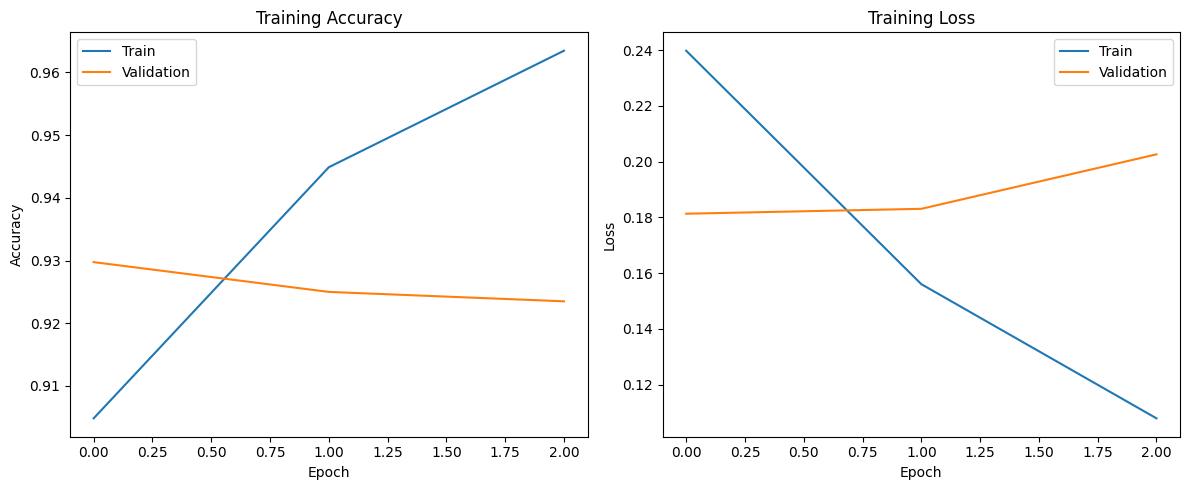

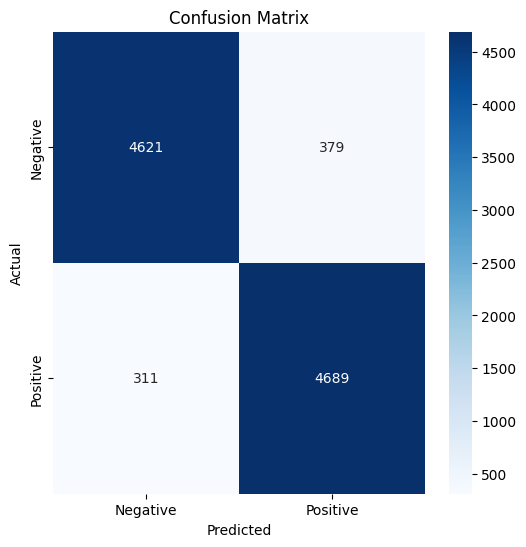

Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.92      0.93      5000
    Positive       0.93      0.94      0.93      5000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


Test Accuracy: 0.9310

🌐 Launching Web Interface...

✅ Training complete! Access the GUI at the URL below:
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://705f96b4e2e89ffe18.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



=== Results saved to ===
Model: /content/drive/MyDrive/sentiment_model_fresh.pth
Outputs: /content/drive/MyDrive/sentiment_results_fresh


In [49]:
"""STEP 7: Main Execution (Robust Version)"""

if __name__ == "__main__":
    try:
        print("=== Starting Fresh Model Training ===")

        # 1. Verify NLTK data
        print("\n🔍 Verifying NLTK resources...")
        nltk.download(['punkt', 'wordnet', 'omw-1.4', 'punkt_tab'], quiet=True)

        # 2. Train the model
        print("\n🚀 Training model...")
        model, tokenizer, test_loader, history = train_fresh_model()

        # 3. Generate evaluation metrics
        print("\n📊 Evaluating model...")
        evaluate_and_visualize(model, test_loader, history)

        # 4. Launch GUI
        print("\n🌐 Launching Web Interface...")
        gui = create_gui(model, tokenizer)
        print("\n✅ Training complete! Access the GUI at the URL below:")
        gui.launch(share=True)

    except Exception as e:
        print(f"\n❌ Error encountered: {str(e)}")
        print("Troubleshooting tips:")
        print("- Run 'nltk.download(['punkt', 'wordnet', 'omw-1.4', 'punkt_tab'])' manually")
        print("- Restart runtime and try again")
        print("- Check Google Drive connection")
    finally:
        print(f"\n=== Results saved to ===")
        print(f"Model: {NEW_MODEL_PATH}")
        print(f"Outputs: {NEW_OUTPUT_DIR}")